# Stock Market Price Prediction with New Data

### Breif Overview:
The model created below is for prediction the stock prices of a Company.

There are two datasets

1. Stock Prices Dataset for Dow Jones Inc

2. Top 25 headlines for everyday for the past 8 years

The notebook is briefly summarized as follows:

1. Data Preparation - Preparing data for evaluation.

2. Data Quality Checks - Performing basic checks on data for better understanding of data.

3. Feature inspection and filtering - Correlation and feature Mutual information plots against the target variable. Inspection of the Binary, categorical and other variables.

4. Feature importance ranking via learning models

5. Training - training data against multiple machine learning algorthms and fine tuning a couple of algorithms for accuracy


## Clients:

### Listed Companies:

Currently the prediction model is only for one company. But the same model can further be used to predict stock prices for any of the companies listed on Nasdaq. The companies can use the model to predict the company’s stock prices and make business decisions.

Ex: Dow Jones, Apple, Google etc

### Stock Brokers, Brokerage Firms and Buyers:

The other set of customers would be stock brokers and buyers who would want to predict stock prices and make decisions (buy or sell) accordingly. Insights on the seasonal trends and growth can be analyzed using the model.

Ex: Gardner Rich & Co, Charles Schwab, Stratton Oakmont etc

# 1. Preprocessing 


In [1]:
import sklearn
from sklearn import svm

In [4]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

## Loading the packages that we will use in our model

In [3]:


import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
#from pandas import read_csv, set_option
from pandas import Series, datetime
from pandas.tools.plotting import scatter_matrix, autocorrelation_plot


In [4]:
!pip install xgboost

    100% |████████████████████████████████| 645kB 13.4MB/s 
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /Users/zeshiyang/Library/Caches/pip/wheels/8a/89/0c/4870bb69132698f40889fa956f92e630a36c1fd7173fcc759f
Successfully built xgboost
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.grid_search import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBClassifier
import seaborn as sns

/Users/yangyu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/yangyu/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



## Loading the datasets: news data and stock price data

## 1. Data Preparation:

Imported all the necessary modules for the project

Loaded the dataset as a dataframe and parsed the date column to be read by the dataframe as dates type
Checked the top 5 rows of the dataframe to see how the columns are aligned.


The 'combined_stock_data.csv' initially only had the headlines(Top1 through Top25). Each row was iterated over an algorithm which generated the Subjectivity, Objectivity, Positive, Negative, Neutral sentiments of the respective headlines of each row.

The algorithm was accepting only a single sentence and was providing the respective sentiments in percentage. I modified the algorithm iterate over all of the individuals rows and simultaneously create the Subjectivity, Objectivity, Negative, Positive, Neutral values and assign itself to the columns in the dataframe.

The headlines Top1 through Top25 were concatenated and then passed on to the algorithm


In [6]:
cd ..

/Users/yangyu/Downloads


In [7]:
#loading the dataset

news_df =pd.read_csv ('combined_stock_data.csv',parse_dates=[1])


In [8]:
news_df.head()

,Unnamed: 0,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,...,Top22,Top23,Top24,Top25,Para,Subjectivity,Objectivity,Positive,Neutral,Negative
0,0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...",...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",75.000000,25.000000,18.750000,25.000000,56.250000
1,1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,83.333333,16.666667,41.666667,16.666667,41.666667
2,2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,...,b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b'Remember that adorable 9-year-old who sang a...,56.250000,43.750000,18.750000,43.750000,37.500000
3,3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",...,b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,b' U.S. refuses Israel weapons to attack Iran:...,38.461538,61.538462,15.384615,61.538462,23.076923
4,4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,b'All the experts admit that we should legalis...,45.454545,54.545455,36.363636,54.545455,9.090909


#### Checked the datatypes of all of the columns. Below is the list of data types

#### All of the data types(Top1 to Top25) below are of object type. But it doesn't matter here as we are not going to use that data, instead we are going to use the polarity data that was produced by that data.

In [9]:
# Check the shape and data types of the dataframe
news_df.shape
news_df.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
Label                    int64
Top1                    object
Top2                    object
Top3                    object
Top4                    object
Top5                    object
Top6                    object
Top7                    object
Top8                    object
Top9                    object
Top10                   object
Top11                   object
Top12                   object
Top13                   object
Top14                   object
Top15                   object
Top16                   object
Top17                   object
Top18                   object
Top19                   object
Top20                   object
Top21                   object
Top22                   object
Top23                   object
Top24                   object
Top25                   object
Para                    object
Subjectivity           float64
Objectivity            float64
Positive               float64
Neutral 

#### Load the Dow Jones dataset to a dataframe stock_data which contains 8 years of Stock Price data.

#### Parse the date as a date type and check the top 5 rows of the dataframe.

#### Checked the top 5 rows of the dataframe

#### By doing this we get a basic sense of how the data looks like, it relationaship, variance in general.

In [11]:
# Load the stock prices dataset into a dataframe and check the top 5 rows

stock_df = pd.read_csv("DJIA_table.csv", parse_dates=[0])
stock_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


#### Checked the shape and datatypes of the loaded dataset

#### It looks like we have one of the columns that has is of type int.

#### Lets change the data type of the column of type int to type float, this is to maintain uniformity accross columns when performing arithmatic operations

In [12]:
# Check the shape and datatypes of the stock prices dataframe
stock_df.shape
stock_df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
Adj Close           float64
dtype: object

## Combine the News data and stock price data together

#### Merged the 5 columns(Subjectivity, Objectivity, Positive, Negative, Neutral) with the stock_data dataframe.

#### Validated the merged dataframe to see the 2 dataframes are concatenated by checking the top 5 rows of the merged_dataframe.

#### Lets take a look at the head of the newly merged data set, again just to get a basic sense of how the data could be correlated, the range of the data and also to see if the operation(merging dataset) we performed is fine.

In [13]:
# Create a dataframe by merging the headlines and the stock prices dataframe
merge_df = news_df[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']].merge(stock_df, how='inner', on='Date', left_index=True)
# Check the shape and top 5 rows of the merged dataframe
merge_df.shape
merge_df.head()

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,1,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,0,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1985,2008-08-13,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1984,2008-08-14,1,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


#### We have the Label(i.e the output column) column in the 2nd position.

#### Lets move it to the end of the dataframe to have a clear view of inputs and outputs

In [16]:
# Push the Label column to the end of the dataframe
cols = list(merge_df)
cols
cols.append(cols.pop(cols.index('Label')))
merge_df = merge_df.loc[:, cols]
merge_df.head()

,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
1988,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0
1987,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1
1986,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0
1985,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0
1984,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,1


#### We have the volumn column in Integer format. Lets change it to float, same as the rest of the columns so we do not have any difficulties in making calculations at a later point.


In [17]:
# Change the datatype of the volume column to float
#merged_dataframe['Date'] = pd.to_datetime(merged_dataframe['Date'])
merge_df['Volume'] = merge_df['Volume'].astype(float)
print(cols)
#merged_dataframe = merged_dataframe.set_index(['Date'])
merge_df.index = merge_df.index.sort_values()
merge_df.head()

['Date', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Label']


,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
0,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,0
1,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,1
2,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,0
3,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,0
4,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,1


## 2. Data Quality Checks:

#### Checked the statistics of individual columns in the dataframe.

#### As you can see below there are no outliers in any of the columns, however, some of the columns have NaN values

#### The NaN values are mostly dummy variables and it is important for those to be replaced. The NaN values could cause the classifier to predict incorrectly. It can be observed from the below data that there are about 3 NaN values in each of the Polaity columns data i.e (Subjectivity, Objectivity, Positive, Negative, Neutral).

#### We will replace the NaN in the cells below. Since we have only 3 NaN values, its impact on the data is going to be relatively less. So, in this case I am going to just replace the NaN's with the Mean value of the respective column as that would be the most appropriate decision in this case.

In [18]:
# Check the statistics of the columns of the merged dataframe and check for outliers
merge_df.describe()


,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
count,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000,1989.000000
mean,56.712522,43.287478,19.966718,36.745804,43.287478,13459.116048,13541.303173,13372.931728,13463.032255,1.628110e+08,13463.032255,0.535445
std,21.557927,21.557927,16.373424,21.109970,21.557927,3143.281634,3136.271725,3150.420934,3144.006996,9.392343e+07,3144.006996,0.498867
min,0.000000,0.000000,0.000000,0.000000,0.000000,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,6547.049805,0.000000
25%,40.000000,28.571429,8.333333,21.859903,28.571429,10907.339844,11000.980469,10824.759766,10913.379883,1.000000e+08,10913.379883,0.000000
50%,54.545455,45.454545,18.181818,33.333333,45.454545,13022.049805,13088.110352,12953.129883,13025.580078,1.351700e+08,13025.580078,1.000000
75%,71.428571,60.000000,28.571429,50.000000,60.000000,16477.699219,16550.070312,16392.769531,16478.410156,1.926000e+08,16478.410156,1.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,18315.060547,18351.359375,18272.560547,18312.390625,6.749200e+08,18312.390625,1.000000


#### Plotted histograms for individual columns to see the distribution of values.

#### The x axis is the column values and the y axis is the frequency of those values.

#### The plot below gives a fair idea of how the data is distributed across columns. We can see that most of the columns though not normally distributed are fairly evenly distributed across all the columns which is a good sign as we do not have to skew much with the data.

#### The Label column has only 0's and 1's. The distribution of this column is most important to be checked. We can see that spread of 0's and 1's are almost equal with the 0's being a little less than the 1's. But a slight difference doesnt matter much. A higher difference will require further transformations to be performed for the data to be equally distributed.

#### We need to have equal number of classifier variables because, even if one of the classifier variables are very low, the classifier will lead to bias and will find difficulty in predicting that particular variable. This will lead to the model predicting only the variable with higher distribution.

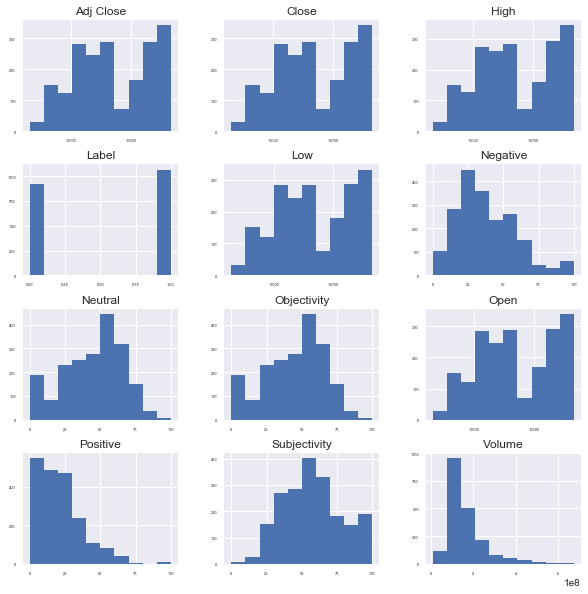

In [19]:
# Plot a histogram for all the columns of the dataframe. This shows the frequency of values in all the columns
import seaborn as sns
sns.set()
merge_df.hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4, figsize=(10, 10))
plt.show()

#### Plot 1: Scatter plot of Stock Prices vs the Subjectivity.<br/>
        Stock Value of 0 means the Stock Value reduced since the previous day.<br/>
        Stock Value of 1 means the Stock Value increased or remained the same since the previous day.

#### Plot 2: Scatter plot of Stock Prices vs the Objectivity.<br/>
        Stock Value of 0 means the Stock Value reduced since the previous day.<br/>
        Stock Value of 1 means the Stock Value increased or remained the same since the previous day.

#### Plot 3: Histogram of Subjectivity column.<br/>
        The x axis are the values of Subjectivity and y axis is its respective frequency.<br/>
        The plot seems to be normally distributed.

#### Plot 4: Histogram of Objectivity column.<br/>
        The x axis are the values of Objectivity and y axis is its respective frequency.<br/>
        The plot seems to be normally distributed.<br/>


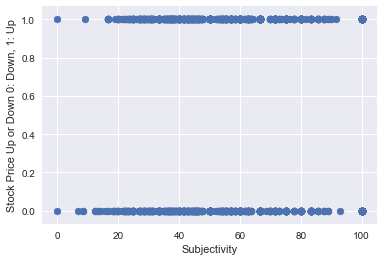

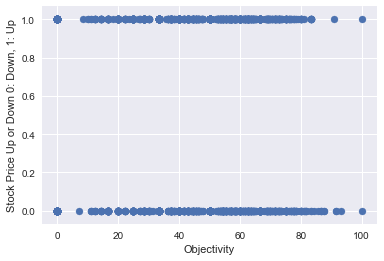

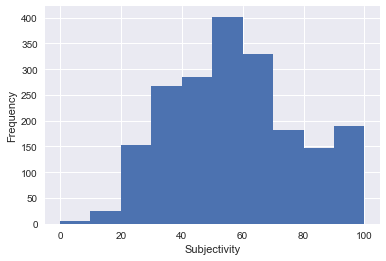

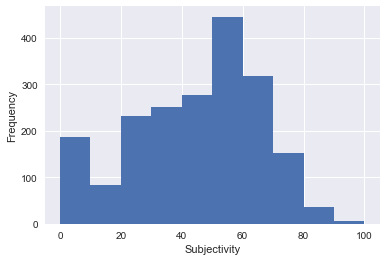

the number of days 
Label
0     924
1    1065
dtype: int64
Size of the Labels column (%)
2
Label
0    46.455505
1    53.544495
dtype: float64 %


In [20]:
plt.scatter(merge_df['Subjectivity'], merge_df['Label'])
plt.xlabel('Subjectivity')
plt.ylabel('Stock Price Up or Down 0: Down, 1: Up')
plt.show()
plt.scatter(merge_df['Objectivity'], merge_df['Label'])
plt.xlabel('Objectivity')
plt.ylabel('Stock Price Up or Down 0: Down, 1: Up')
plt.show()
merge_df['Subjectivity'].plot('hist')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.show()
merge_df['Objectivity'].plot('hist')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')


##for i, v in enumerate(y):
    ##ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

plt.show()
print("the number of days ")

print(merge_df.groupby('Label').size())
print("Size of the Labels column (%)")
print(len(merge_df.groupby('Label')))
print(100*merge_df.groupby('Label').size()/len(merge_df), str("%"))

## 3.Feature inspection and filtering

#### Lets check for NaN values in individual columns of the dataframe.

#### Visualizing the NaN's makes it easier for us to see where the NaN values are falling. Below is a plot of the NaN values. The white lines are the NaN values. In the below plot we are unable to see the NaN values because they are so less. We just have 3 NaN values in the first 4 columns each. The perpendicular bars on the last vertical lin shows exactly where the NaN values are falling.

#### In this case, since the NaN values are so less, it doesn't matter much in the prediction of the model. However, it is important for the NaN values to be replaced. As discuseed earlier, we will replace the NaN values with the mean value of the respective column.

In [21]:
##md_copy = merged_dataframe
#md_copy = md_copy.replace(-1, np.NaN)#
#import missingno as msno
# Nullity or missing values by columns
#msno.matrix(df=md_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))#

## Correlation Map for features:

#### Now, we will plot a heat map and a scatter matrix to see the correlation of the columns with each other.

#### You can see the heat map with pearson correlation values in the plot below.

#### This gave me a better understanding to see if there are any dependant variables or if any of the variables are highly correlated.

#### Some variables Subjectivity, Objectivity are negatively correlated. There are very few variables which seem to have a very high correlation. Thus, at this point we can conclude that we do not need any sort of dimensionality reduction technique to be applied.

#### Some machine learning algorithms require the predictor variables to not be highly correlated. If the predictors are highly correlated then all of the correlated predictors are basically representing the same correlation and either one or all the variables will have the same effect on the target variable. In such a case dimensionality reduction is required. 

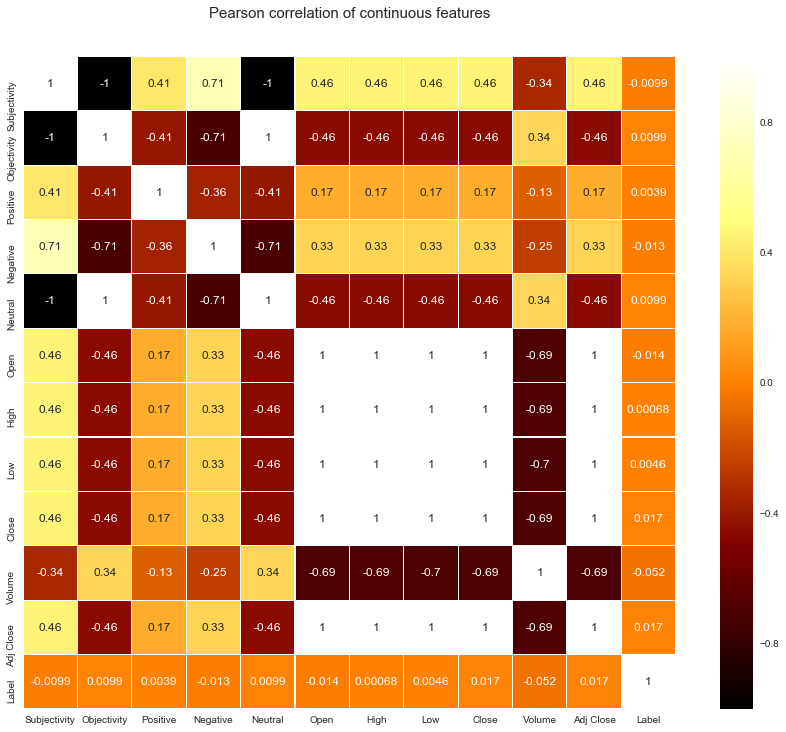

In [24]:
from matplotlib import pyplot as plt
colormap = plt.cm.afmhot
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(merge_df.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
plt.show()

In [25]:
%matplotlib inline
!pip install plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [26]:

bin_col = merge_df.columns
zero_list = []
one_list = []
for col in bin_col:
    zero_count = 0
    one_count = 0
    for ix, val in merge_df[col].iteritems():
        if merge_df.loc[ix, 'Label'] == 0:
            zero_count += 1
        else:
            one_count += 1
    zero_list.append(zero_count)
    one_list.append(one_count)
    
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

## 4. Training:

### Steps being performed in the below cell:

Recheck the dataframe to see if the dataset is ready for train.

There are certain NaN values in many columns of the dataframe.

Replace the NaN values with the mean values of the respective column.

Split the merged dataframe to inputs(X) and outputs(y)

In our dataset, we have columns Subjectivity through Adj Close as inputs and the Label column output.

Now, we will split our dataset to training and test samples. Lets train out model on first 70% of the data 
and test our prediction model on remaining 30% of the data.

As this is a time series, it is important we do not randomly pick training and testing samples. A time series is a linear dataset where the data is in a chronological order. This requires the chronology to be preserved in while training the model and doing the prediction. This is why it is important to maintain a proper chronological split.

#### Lets consider a few machine learning algorithms to perform our training on.

Logistic Regression

Linear Discriminant Analysis

K Nearest Neighbors

Decision trees

Naive Bayes

Support Vector Classifier

Random Forest Classifier

#### Lets add all of these classifiers to a list 'models'

After splitting the dataset, we can see that there are 1393 samples for training and 597 samples for testing


In [32]:
# Print the datatypes and count of the dataframe
merge_df.dtypes
merge_df.count()
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    merge_df[col] = merge_df[col].fillna(merge_df[col].mean())

# Recheck the count
merge_df.count()
# Recheck the count
merge_df.head()

,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
0,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,0
1,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,1
2,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,0
3,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,0
4,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,1


In [33]:

# Separate the dataframe for input(X) and output variables(y)
X = merge_df.loc[:,'Subjectivity':'Adj Close']
y = merge_df.loc[:,'Label']
# Set the validation size, i.e the test set to 20%
validation_size = 0.20
# Split the dataset to test and train sets
# Split the initial 70% of the data as training set and the remaining 30% data as the testing set
train_size = int(len(X.index) * 0.7)
print(len(y))
print(train_size)


1989
1392


In [36]:

X_train, X_test = X.loc[0:train_size], X.loc[train_size: len(X.index)]
y_train, y_test = y.loc[0:train_size], y.loc[train_size: len(X.index)]





Observations:  1989
X Training Observations:  1393
X Testing Observations:  597
y Training Observations:  1393
y Testing Observations:  597


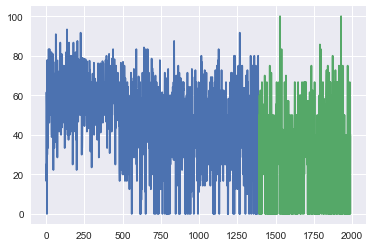

In [37]:

print('Observations: ',len(X.index))
print('X Training Observations: ', (len(X_train)))
print('X Testing Observations: ', (len(X_test)))
print('y Training Observations: ', (len(y_train)))
print('y Testing Observations: ' , (len(y_test)))
plt.plot(X_train['Objectivity'])
plt.plot([None for i in X_train['Objectivity']] + [x for x in X_test['Objectivity']])
plt.show()
num_folds = 10
scoring = 'accuracy'


In [40]:
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('SVM' , SVC()))
models.append(('DT' , DecisionTreeClassifier()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('XGBoost', XGBClassifier()))

In [41]:
# standardlized the x_train and x_test set

In [42]:
scaler = StandardScaler().fit(X_train)
#scaled_X_train = scaler.transform(X_train)
#scaled_X_test = scaler.transform(X_test)








# Model building

#### Now, we will iterate over all of the machine learning classifiers and in each loop , we will train against the algorithm, predict the outputs with inputs from the testing split.

#### The process of training involves each individual model learning from its predictors and the respective output. Once the model learns it, the model is ready to perform the prediction. The prediction is performed on the testing set without giving away the output of the testing set to the model.

#### The actual and the predicted outputs are compared to calculate the accuracy.

#### We see that LDA seems to be giving a high accuracy score, but accuracy is still not the most trustworthy measure.


## 1. model k-fold cross-validation result

In [43]:
import warnings

warnings.filterwarnings('ignore')
# Evaluate each algorithm for accuracy
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    
    results.append(cv_results)

    names.append(name)
   
    Res = "%s: %f (%s) %f (%s)" % ("k-fold validation result for "+ name+" is: ", cv_results.mean(),"mean",cv_results.std(),"standard deviation")
    print(Res) 
    
'''for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))'''

k-fold validation result for LR is: : 0.526973 (mean) 0.056715 (standard deviation)
k-fold validation result for KNN is: : 0.505288 (mean) 0.049119 (standard deviation)
k-fold validation result for SVM is: : 0.537688 (mean) 0.052752 (standard deviation)
k-fold validation result for DT is: : 0.608155 (mean) 0.101930 (standard deviation)
k-fold validation result for RF is: : 0.578582 (mean) 0.055369 (standard deviation)
k-fold validation result for LDA is: : 0.918844 (mean) 0.026559 (standard deviation)
k-fold validation result for XGBoost is: : 0.620180 (mean) 0.076039 (standard deviation)


'for name, model in models:\n    clf = model\n    clf.fit(X_train, y_train)\n    y_pred = clf.predict(X_test)\n    accu_score = accuracy_score(y_test, y_pred)\n    print(name + ": " + str(accu_score))'

In [44]:

for name, model in models:
    aaaaaa = model
    
     
    #aaaaaa.fit(rescaledX, y_train)
    aaaaaa.fit(X_train, y_train)
    y_pred = aaaaaa.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print("Test set prediction accuracy score for: ", name + ": " + str(accu_score))
    

Test set prediction accuracy score for:  LR: 0.5309882747068677
Test set prediction accuracy score for:  KNN: 0.45896147403685095
Test set prediction accuracy score for:  SVM: 0.5309882747068677
Test set prediction accuracy score for:  DT: 0.5728643216080402
Test set prediction accuracy score for:  RF: 0.541038525963149
Test set prediction accuracy score for:  LDA: 0.9430485762144054
Test set prediction accuracy score for:  XGBoost: 0.5862646566164154


In [47]:

# prepare
#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler().fit(X_train)

rescaledX = scaler.transform(X_train)



### (1)Accurcy for LDA MODEL

    100% |████████████████████████████████| 286kB 8.3MB/s 
    100% |████████████████████████████████| 7.9MB 5.5MB/s 
distributed 1.21.8 requires msgpack, which is not installed.
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
 Accuracy score: 
 0.9430485762144054
Confusion matrix: 
 [[254  26]
 [  8 309]]
Classification report: 
              precision    recall  f1-score   support

          0       0.97      0.91      0.94       280
          1       0.92      0.97      0.95       317

avg / total       0.94      0.94      0.94       597



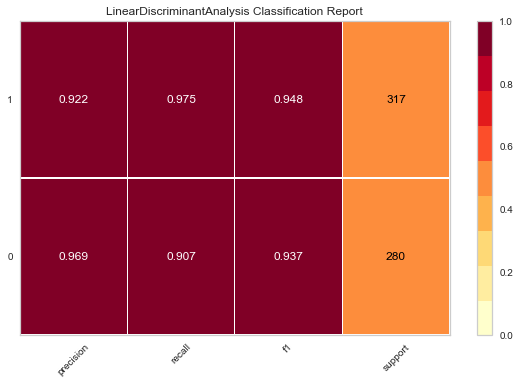

In [94]:
!pip install yellowbrick
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predict_lda = model_lda.predict(rescaledValidationX)

print(" Accuracy score: \n",accuracy_score(y_test, predict_lda))
print("Confusion matrix: \n",confusion_matrix(y_test, predict_lda))
print("Classification report: \n",classification_report(y_test, predict_lda))
from yellowbrick.classifier import ClassificationReport
classes = ["0", "1"]
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(LinearDiscriminantAnalysis(), classes=classes, support=True)

visualizer.fit(rescaledX, y_train)  # Fit the visualizer and the model
visualizer.score(rescaledValidationX, y_test)  # Evaluate the model on the test data
visualizer.poof()


## (2)KNN model

 Accuracy score: 
 0.5326633165829145
Confusion matrix: 
 [[132 148]
 [131 186]]
Classification report: 
              precision    recall  f1-score   support

          0       0.50      0.47      0.49       280
          1       0.56      0.59      0.57       317

avg / total       0.53      0.53      0.53       597



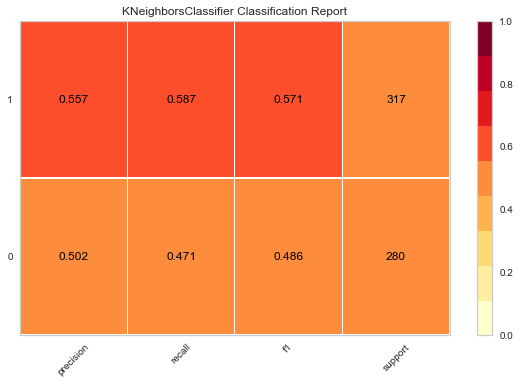

In [95]:

model_knn = KNeighborsClassifier()
model_knn.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predict_knn = model_knn.predict(rescaledValidationX)

print("\033[1;34;43m Accuracy score: \033[0m\n",accuracy_score(y_test,predict_knn))
print("Confusion matrix: \n",confusion_matrix(y_test, predict_knn))
print("Classification report: \n",classification_report(y_test, predict_knn))

from yellowbrick.classifier import ClassificationReport
classes = ["0", "1"]
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(KNeighborsClassifier(), classes=classes, support=True)

visualizer.fit(rescaledX, y_train)  # Fit the visualizer and the model
visualizer.score(rescaledValidationX, y_test)  # Evaluate the model on the test data
visualizer.poof()


## (3)Logistic model

accuracy score:
 0.9028475711892797
confusion matrix: 
 [[225  55]
 [  3 314]]
classification report: 
              precision    recall  f1-score   support

          0       0.99      0.80      0.89       280
          1       0.85      0.99      0.92       317

avg / total       0.91      0.90      0.90       597



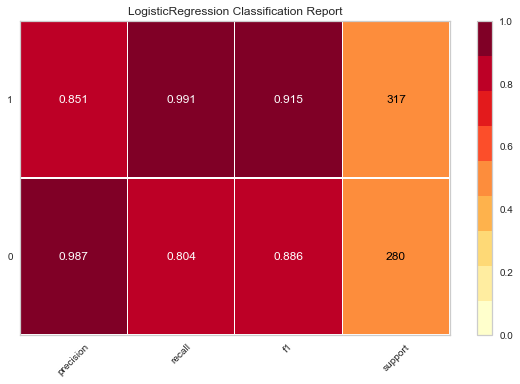

In [96]:

model_LOG =  LogisticRegression()
model_LOG.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predict_LOG = model_LOG.predict(rescaledValidationX)

print("accuracy score:\n",accuracy_score(y_test, predict_LOG))
print("confusion matrix: \n",confusion_matrix(y_test, predict_LOG))
print("classification report: \n",classification_report(y_test, predict_LOG))
from yellowbrick.classifier import ClassificationReport
classes = ["0", "1"]
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(LogisticRegression(), classes=classes, support=True)

visualizer.fit(rescaledX, y_train)  # Fit the visualizer and the model
visualizer.score(rescaledValidationX, y_test)  # Evaluate the model on the test data
visualizer.poof()

## (4)SVM

accuracy score:
 0.5527638190954773
confusion matrix: 
 [[ 91 189]
 [ 78 239]]
classification report: 
              precision    recall  f1-score   support

          0       0.54      0.33      0.41       280
          1       0.56      0.75      0.64       317

avg / total       0.55      0.55      0.53       597



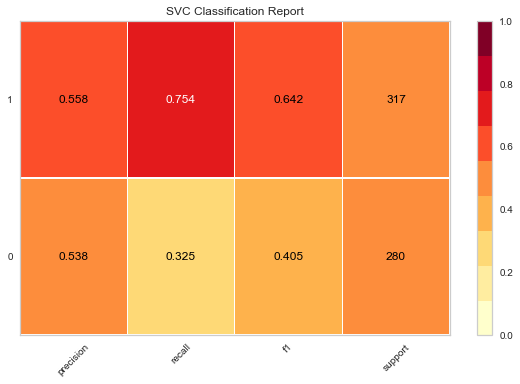

In [97]:
model_SVM =  SVC()
model_SVM.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predict_SVM = model_SVM.predict(rescaledValidationX)

print("accuracy score:\n",accuracy_score(y_test, predict_SVM))
print("confusion matrix: \n",confusion_matrix(y_test, predict_SVM))
print("classification report: \n",classification_report(y_test, predict_SVM))

from yellowbrick.classifier import ClassificationReport
classes = ["0", "1"]
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(SVC(), classes=classes, support=True)

visualizer.fit(rescaledX, y_train)  # Fit the visualizer and the model
visualizer.score(rescaledValidationX, y_test)  # Evaluate the model on the test data
visualizer.poof()

## (5)Decision trees

accuracy score:
 0.5527638190954773
confusion matrix: 
 [[210  70]
 [197 120]]
classification report: 
              precision    recall  f1-score   support

          0       0.52      0.75      0.61       280
          1       0.63      0.38      0.47       317

avg / total       0.58      0.55      0.54       597



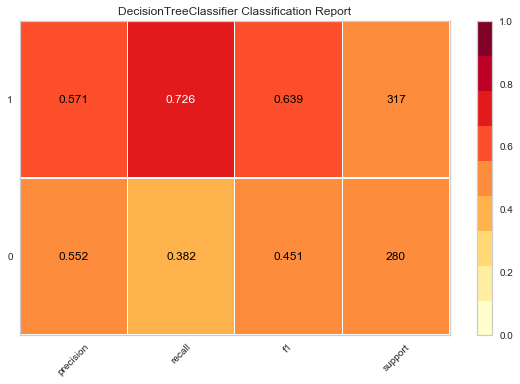

In [98]:
model_DT = DecisionTreeClassifier()
model_DT.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predict_DT = model_DT.predict(rescaledValidationX)

print("accuracy score:\n",accuracy_score(y_test, predict_DT))
print("confusion matrix: \n",confusion_matrix(y_test, predict_DT))
print("classification report: \n",classification_report(y_test, predict_DT))

from yellowbrick.classifier import ClassificationReport
classes = ["0", "1"]
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(DecisionTreeClassifier(), classes=classes, support=True)

visualizer.fit(rescaledX, y_train)  # Fit the visualizer and the model
visualizer.score(rescaledValidationX, y_test)  # Evaluate the model on the test data
visualizer.poof()

## (6)Random Forest

accuracy score:
 0.5443886097152428
confusion matrix: 
 [[126 154]
 [118 199]]
classification report: 
              precision    recall  f1-score   support

          0       0.52      0.45      0.48       280
          1       0.56      0.63      0.59       317

avg / total       0.54      0.54      0.54       597



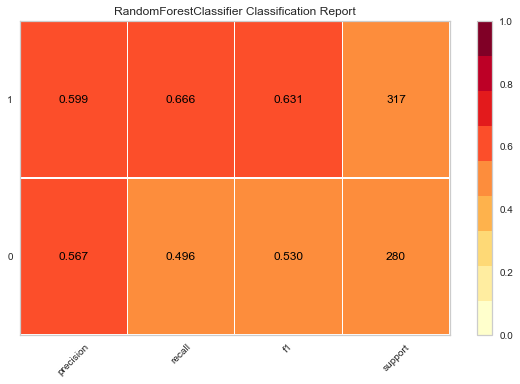

In [99]:
model_rf= RandomForestClassifier(n_estimators=50)
model_rf.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predict_rf = model_rf.predict(rescaledValidationX)

print("accuracy score:\n",accuracy_score(y_test, predict_rf))
print("confusion matrix: \n",confusion_matrix(y_test, predict_rf))
rf0=classification_report(y_test, predict_rf)
#rf = confusion_matrix(y_test, predict_rf)/confusion_matrix(y_test, predict_rf).astype(np.float).sum(axis=1)
#sns.heatmap(rf, annot=True)

print("classification report: \n",classification_report(y_test, predict_rf))

from yellowbrick.classifier import ClassificationReport
classes = ["0", "1"]
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(RandomForestClassifier(n_estimators=50), classes=classes, support=True)

visualizer.fit(rescaledX, y_train)  # Fit the visualizer and the model
visualizer.score(rescaledValidationX, y_test)  # Evaluate the model on the test data
visualizer.poof()

## GridSearchCV(estimator=svc, param_grid=dict(C=Cs)

accuracy score:
 0.9731993299832495
confusion matrix: 
 [[272   8]
 [  8 309]]
classification report: 
              precision    recall  f1-score   support

          0       0.97      0.97      0.97       280
          1       0.97      0.97      0.97       317

avg / total       0.97      0.97      0.97       597



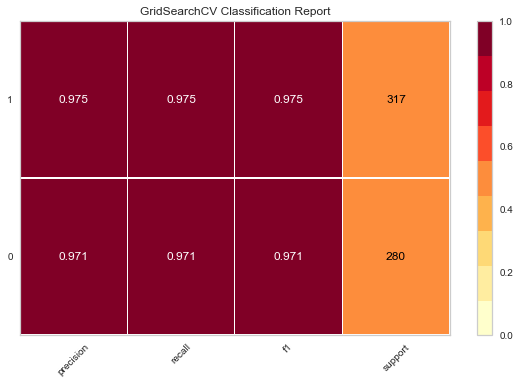

In [100]:
params = [
        {'kernel': ['linear'], 'C': [1, 10, 100, 100]},
        {'kernel': ['poly'], 'C': [1], 'degree': [2, 3]},
        {'kernel': ['rbf'], 'C': [1, 10, 100, 100], 'gamma':[1, 0.1, 0.01, 0.001]}
        ]

model_GS2 = GridSearchCV(SVC(), params, scoring='roc_auc', cv=10 )
model_GS2.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predict_GS2 = model_GS2.predict(rescaledValidationX)
GS_REPORT2 = classification_report(y_test, predict_GS2)
print("accuracy score:\n",accuracy_score(y_test, predict_GS2))
print("confusion matrix: \n",confusion_matrix(y_test, predict_GS2))
print("classification report: \n",classification_report(y_test, predict_GS2))
from yellowbrick.classifier import ClassificationReport
classes = ["0", "1"]
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(GridSearchCV(SVC(), params, scoring='roc_auc', cv=10 ), classes=classes, support=True)

visualizer.fit(rescaledX, y_train)  # Fit the visualizer and the model
visualizer.score(rescaledValidationX, y_test)  # Evaluate the model on the test data
visualizer.poof()

In [102]:
for name, model in models:
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print("Test set prediction accuracy score for: ", name + ": " + str(accu_score))
    

Test set prediction accuracy score for:  LR: 0.5309882747068677
Test set prediction accuracy score for:  KNN: 0.45896147403685095
Test set prediction accuracy score for:  SVM: 0.5309882747068677
Test set prediction accuracy score for:  DT: 0.5812395309882747
Test set prediction accuracy score for:  RF: 0.5393634840871022
Test set prediction accuracy score for:  LDA: 0.9430485762144054
Test set prediction accuracy score for:  XGBoost: 0.5862646566164154


## XGBOOST

accuracy score:
 0.5862646566164154
confusion matrix: 
 [[ 36 244]
 [  3 314]]
classification report: 
              precision    recall  f1-score   support

          0       0.92      0.13      0.23       280
          1       0.56      0.99      0.72       317

avg / total       0.73      0.59      0.49       597



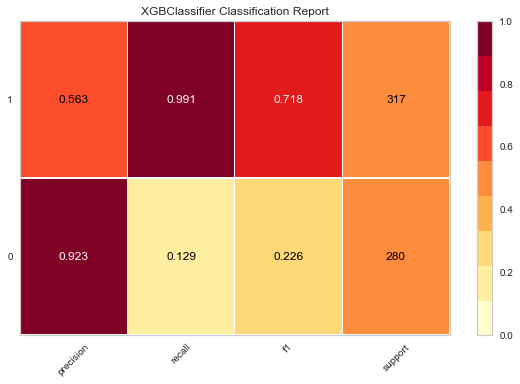

In [103]:
model_xgb = XGBClassifier()
model_xgb.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_xgb.predict(rescaledValidationX)

print("accuracy score:\n",accuracy_score(y_test, predictions))
print("confusion matrix: \n",confusion_matrix(y_test, predictions))
print("classification report: \n",classification_report(y_test, predictions))

from yellowbrick.classifier import ClassificationReport
classes = ["0", "1"]
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(XGBClassifier(), classes=classes, support=True)

visualizer.fit(rescaledX, y_train)  # Fit the visualizer and the model
visualizer.score(rescaledValidationX, y_test)  # Evaluate the model on the test data
visualizer.poof()

#### As data distributions are in varying ranges, it would be good to scale all of our data and then use it to train our algorithm.

#### The numerical range in each of the columns are in different ranges. Sometimes getting all the data in all columns to the same range helps better train the model. We can use a method StandardScalar to scale the data.

#### Lets print out the accuracy score, confusion matrix.

#### Below we are scaling the data and training using LDA and XGBoost. It can be seen that even after scaling the data the accuracy hasn't changed much and is still at 94% and 58% accuracy respectively for LDA and XGBoost.


#### In the cell below, we are calculating the AUC score and plotting the ROC AUC curve. This is done to checking if LDA is performing well or not.

#### The curve plots a line and the higher the area under the curved line, the better the model.

#### We can see below that the AUC score is 0.5 and the under the curve as seen is about 50%. This score is worthless and and explains that the LDA is badly trained. The AUC score has to be more than 0.5 and the higher the score, the better the performance. A score of 0.5 only shows that LDA is a worthless model.

In [104]:
# Scaling Random Forests

model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_rf.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))


accuracy score:
0.5644891122278057
confusion matrix: 
[[131 149]
 [111 206]]
classification report: 
             precision    recall  f1-score   support

          0       0.54      0.47      0.50       280
          1       0.58      0.65      0.61       317

avg / total       0.56      0.56      0.56       597



## 5. Feature Importances:

#### Below you can find the feature with highest to least important features plotted in the graph.

#### This is for XGBoost. We are using the feature importance function provided by XGBoost to check which are the predictor variables which have the highest effect on training the model. This is done to check if some of the predictor variables which have the least effect on training can be removed. Once the least effective predictors are removed, the model can be trained again which usually leads to better accuracy.

#### Below we can see that 'Low' and 'Neutral' columns have the highest effect in training the model.

#### There are other columns 'Close', 'Objectivity', 'Date', 'Positive' which have certain effect in the model, but the remaining columns do not have any effect and can thus be ignored.

#### In the cells ahead, we will try removing the non effective columns and train again to see if the accuracy of the model can be improved.

In [145]:
features = merge_df.drop(['Label'],axis=1).columns.values

x, y = (list(x) for x in zip(*sorted(zip(model_xgb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature importance for XGBoost',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances for XGBoost',
     width = 1000, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


#### Below is the feature importance graph for Random Forests.

#### This is just to see the sample important features for Random Forests. We are not going to use Random Forests for further tuning our model.

In [77]:
x, y = (list(x) for x in zip(*sorted(zip(model_rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature importance for Random Forests',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances for Random Forests',
     width = 1000, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


## Fine Tuning XGBoost

#### As of now the model that seems to be performing the best is the XGBoost model.

#### Lets see if we can fine tune it further to increase the accuracy of the model.

#### The main parameters which can be used for fine tuning the XGBoost model are the n_estimators and the max_depth parameters.

#### n_estimators: XGBoost is an additive model, multiple models are created on different samples of data and the model learns after training of different samples. How many samples are the optimum best for the XGBoost to train from is usually unknown and the best way to find out is to check by training on different set of estimators.

#### Lets take a list of n_estimators = [150, 200, 250, 450, 500, 550, 1000]

#### max_depth: XGBoost learns in the form of a tree model and the number of depths for that tree needs to be set. This parameter is also not known. So lets try on multiple set of depths.
#### max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

#### Below , we are training the XGBoost classifier on different combinations of max depth and estimators. This output will print out the  best parameters as well as the highest accuracy achieved using those parameters.

#### Below we can see that the accuracy has improved by around ~5%, i. e from 58% to 62% at 550 estimators and max depth of 3.

In [114]:
# XGBoost on Stock Price dataset, Tune n_estimators and max_depth
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib

matplotlib.use('Agg')
model = XGBClassifier()
n_estimators = [150, 200, 250, 300, 350, 400, 450, 480, 490, 500, 510, 520, 550, 1000]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Score is 0.5711892797319933 at depth of 1 and estimator 150
Score is 0.5879396984924623 at depth of 2 and estimator 150
Score is 0.5879396984924623 at depth of 3 and estimator 150
Score is 0.5879396984924623 at depth of 4 and estimator 150
Score is 0.5829145728643216 at depth of 5 and estimator 150
Score is 0.5879396984924623 at depth of 6 and estimator 150
Score is 0.592964824120603 at depth of 7 and estimator 150
Score is 0.5829145728643216 at depth of 8 and estimator 150
Score is 0.5795644891122278 at depth of 9 and estimator 150
Score is 0.5963149078726968 at depth of 10 and estimator 150
Score is 0.5778894472361809 at depth of 1 and estimator 200
Score is 0.5896147403685092 at depth of 2 and estimator 200
Score is 0.5912897822445561 at depth of 3 and estimator 200
Score is 0.592964824120603 at depth of 4 and estimator 200
Score is 0.5795644891122278 at depth of 5 and estimator 200
Score is 0.5896147403685092 at depth of 6 and estimator 200
Score is 

## Fine tuning with important features:

#### As explained earlier in the feature importance plot section, lets use the most important features and see if it improves the accuracy of the model.

#### After training using the most important features, we do not see much improvement in our model. Hence, lets not use that in further tuning. The model accuracy still remains at 62%

In [118]:
imp_features_df = merge_df[['Low', "Neutral", 'Close', 'Objectivity', 'Date']]
Xi_train, Xi_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
clf = XGBClassifier(n_estimators=500, max_depth=3)
clf.fit(Xi_train, y_train)
yi_pred = clf.predict(Xi_test)
score = accuracy_score(y_test, yi_pred)
print("Score is "+ str(score))


Score is 0.6164154103852596


## PCA transformation:
    
#### PCA is another technique for dimensionality reduction. We just need to specify the number the components we need our data to be reduced to and PCA does the job for us.

#### In the below model, lets reduce the dimension of the data down to 3 and then train it using XGBoost to see if the performance is improved. PCA reduces the dimensions of the data, however it preserves the data from all columns, it only does the job of bringing down all the dimensions to 2-3 dimensions. The main dimension will be the dimension with highest amount of variance, i.e the spread of data.

In [140]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X)
transformed = pca.transform(X)

transformed.shape
print(type(transformed))

<class 'numpy.ndarray'>


#### After performing PCA, lets now train our model using XGBoost.

## We can observe below that our model is now giving an accuracy of 94% after performing PCA

In [141]:
pca_df = pd.DataFrame(transformed)

X_train_pca, X_test_pca = pca_df.loc[0:train_size, :], pca_df.loc[train_size: len(X.index), :]

clf = XGBClassifier(n_estimators=100, max_depth=10)
clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)
score = accuracy_score(y_test, y_pred_pca)
print("Score is "+ str(score))


Score is 0.9413735343383585


#### However, as explained earlier, we cannot totally rely on the accuracy score to be the most acurate test of the model . Lets take a look at the confusion matrix as well as the classification report.

#### The confusion matrix looks good as we have a good number of true positives and true negatives.
#### The top left corner is the true positive and the bottom right corner of the matrix is the true negatives.
#### True Positive: No. of predictions which are positive and are actually positive.
#### True Negative: No. of predictions which are negative and are actually negative.
#### The bottom left and top right are false positive and false negative. We can see that the number of false positive's and false negative's are quite low. Thus we can say that the predictions performed by the model is very good.

#### The precision, recal and f1 score is also very good.
## Precision is 0.94
## Recall is 0.94
## f1-score is 0.94

In [48]:
pca_matrix = confusion_matrix(y_test, y_pred_pca)
pca_report = classification_report(y_test, y_pred_pca)
print("Confusion Matrix: \n" + str(pca_matrix))
print("Classification report: \n" + str(pca_report))


Confusion Matrix: 
[[258  22]
 [ 13 304]]
Classification report: 
             precision    recall  f1-score   support

          0       0.95      0.92      0.94       280
          1       0.93      0.96      0.95       317

avg / total       0.94      0.94      0.94       597



#### Finally, lets check the Area Under the Curve by plotting the ROC AUC curve.

#### After plotting the curve , we can observe that the AUC score is 0.98 having around 98% area under the curve which is amazing.

## This suggests that our model is performing good at an accuracy of 94%.
## This can further be used to predict the Stock Prices.
## We are going to need top 25 headlines. These headlines can be parsed to generate the polarity data and use the stock prices to predict the Stock Prices.

AUC score is 0.9830948625506984
roc auc is :0.9830948625506984


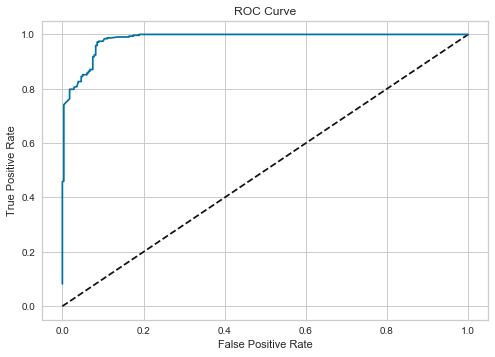

In [151]:
# Generating the ROC curve
y_pred_proba_pca = clf.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pca)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
